# 맞춤형 잡곡 배합 추천 (데이터 드리븐, 설문·영양표 교체형)
- **핵심**: 설문 스키마·영양 매핑을 CSV/JSON으로 분리 → 설문 추가/수정, 영양성분표 변경 시 **파일만 교체**하면 코드 수정 없이 반영
- 구성: `config/` 폴더에
  - `grains_catalog.csv` (곡물 특성)
  - `section_weights.csv` (섹션 가중치)
  - `survey_to_nutrients.csv` (섹션 보기 → 영양 1·2·3)
  - `nutrient_to_grains.csv` (영양 → 잡곡 1·2·3)
  - `survey_schema.json` (동적 설문 UI 스키마)
  - `rule_weights.json` (기타 규칙: 캡/최소치, 알레르겐, 베이스 선택 등)

# 잡곡 점수 계산 방식

추천 배합은 설문 응답과 곡물 특성 데이터를 바탕으로 **점수(score)**를 계산한 뒤,  
베이스/캡/최소치 규칙을 적용하여 100%로 배분한다.

---

## 1. 기본 구조

각 곡물 `g`의 점수는 여러 섹션 점수의 곱으로 계산된다.

\[
Score(g) = 
Purpose(g)^{w_p} \times 
TextureTaste(g)^{w_t} \times 
ConstitutionGut(g) \times 
Frequency(g) \times 
NutrientBonus(g) \times 
AllergenFilter(g)
\]

- \(w_p, w_t\): 섹션 가중치 (지수 형태로 반영)
- 값은 모두 **곱셈형 multiplier**로 누적되며, 1.0에서 시작

---

## 2. 세부 요소

### (a) 목적 점수 `Purpose(g)`
\[
Purpose(g) = \prod_{f} (1 + \alpha_f \cdot x_{g,f}) 
\times GrainBonus(g)
\times GrainPenalty(g)
\]

- \(x_{g,f}\): 곡물의 특성값 (예: 섬유=2, 단백=1, GI=3 등)
- \(\alpha_f\): 해당 특성의 계수
  - **양수 계수**: 높을수록 좋은 특성 (섬유, 단백 등)
  - **음수 계수**: 낮을수록 좋은 특성 (GI 등)



### (b) 식감·맛 점수 `TextureTaste(g)`
\[
TextureTaste(g) = \prod_{f} (1 + \beta_f \cdot x_{g,f}) 
\times GrainBonus(g)
\times \text{ThresholdPenalty}(g)
\]

- 설문 응답(`고슬밥`, `찰진밥`)을 내부 `식감/맛`으로 매핑
- 특정 특성이 기준 이상일 경우 패널티 적용  
  \[
  ThresholdPenalty = 
  \begin{cases}
  m, & x \geq threshold \\
  1, & \text{otherwise}
  \end{cases}
  \]



### (c) 체질·장건강 점수 `ConstitutionGut(g)`
- 설문에서 선택된 체질, 장건강 상태에 따라 보너스/패널티 반영
- 예: 장건강 민감 → 부드러움 높은 곡물에 가중치



### (d) 섭취 빈도 점수 `Frequency(g)`
- 섭취 빈도에 따라 특정 곡물을 밀어주거나 억제



### (e) 영양 보너스 `NutrientBonus(g)`
1. 설문 응답 → 영양 타깃 (예: 혈당관리 → 식이섬유, 단백질)
2. 영양 타깃 → 대표 곡물(랭크 1~3)
3. 섹션 가중치 × 랭크 가중치로 점수 누적
4. 최종 multiplier:
   \[
   NutrientBonus(g) = 1 + \gamma \cdot v
   \]


### (f) 알레르겐 필터 `AllergenFilter(g)`
- `글루텐 회피=True`이고, 곡물이 글루텐 곡물이라면 **0.0** (완전 제외)
- 그 외는 1.0

---

## 3. 최종 점수 예시 (현미)

- 특성값: 섬유=2, 단백=1, GI=2
- 목적: 혈당관리  
  \[
  (1 - 0.12 \times 2) \times (1 + 0.06 \times 2) \times (1 + 0.03 \times 1) = 0.88
  \]
- 식감: 찰진밥 → 쫀득 보너스 적용
- 장건강: 보통 → 영향 없음
- 빈도: 주 3-4회 → 영향 없음
- 영양 보너스: 식이섬유 관련 곡물에 +보너스
- 알레르겐: 글루텐 없음 → 1.0 유지

최종적으로 곱하면 `현미 점수 ≈ 1.51` (상대 점수 기준)

---

## 4. 점수 → 비율 변환

1. 베이스 곡물 선택 (rule_weights.json의 규칙, 혹은 점수 기반 동적 선택)
2. 베이스 최소치 확보 (예: 현미 ≥ 35%)
3. 나머지 퍼센트는 점수 비례로 분배
4. 캡(최대치)·최소치 규칙 적용
5. 합계 100%로 보정 후 정수화



# 코드
## Setup

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [15]:
# 0) Setup
# (필요 시 1회만) 위젯 UI 설치
# !pip install ipywidgets

from pathlib import Path
import json, math
import numpy as np
import pandas as pd

pd.set_option("display.precision", 2)

CONFIG_DIR = Path("config")
CONFIG_DIR.mkdir(parents=True, exist_ok=True)

# 경로
GRAINS_CSV = CONFIG_DIR / "grains_catalog.csv"
SECTION_WEIGHTS_CSV = CONFIG_DIR / "section_weights.csv"
SURVEY_TO_NUTRIENTS_CSV = CONFIG_DIR / "survey_to_nutrients.csv"
NUTRIENT_TO_GRAINS_CSV = CONFIG_DIR / "nutrient_to_grains.csv"
SURVEY_SCHEMA_JSON = CONFIG_DIR / "survey_schema.json"
RULE_WEIGHTS_JSON = CONFIG_DIR / "rule_weights.json"


## 파일 구조 & 로더

In [16]:
# 1) 로더 & 밸리데이션
def load_grains(path=GRAINS_CSV) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "태그" in df.columns:
        df["태그"] = df["태그"].fillna("").map(lambda s: str(s).split(";") if isinstance(s, str) else [])
    return df

def load_rule_weights(path=RULE_WEIGHTS_JSON) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_section_weights(path=SECTION_WEIGHTS_CSV, fallback_json=None) -> dict:
    if Path(path).exists():
        df = pd.read_csv(path)
        out = {str(r["section"]): float(r["weight"]) for _, r in df.iterrows()}
        return out
    return dict((fallback_json or {}).get("section_weights", {}))

def load_survey_to_nutrients(path=SURVEY_TO_NUTRIENTS_CSV, fallback_json=None) -> dict:
    # 반환 형태: {section: {option: [nut1, nut2, nut3] } }
    if Path(path).exists():
        df = pd.read_csv(path)
        df = df.fillna("")
        out = {}
        for (sec, opt), g in df.groupby(["section","option"]):
            ranks = g.sort_values("rank")
            lst = [x for x in ranks["nutrient"].tolist() if str(x).strip() != ""]
            out.setdefault(sec, {})[opt] = lst
        return out
    return dict((fallback_json or {}).get("survey_to_nutrients", {}))

def load_nutrient_to_grains(path=NUTRIENT_TO_GRAINS_CSV, fallback_json=None) -> dict:
    # 반환 형태: {nutrient: [g1, g2, g3]}
    if Path(path).exists():
        df = pd.read_csv(path)
        out = {}
        for nut, g in df.groupby("nutrient"):
            ranks = g.sort_values("rank")
            out[nut] = ranks["grain"].tolist()
        return out
    return dict((fallback_json or {}).get("nutrient_to_grains", {}))

def norm_section_weights(sw: dict) -> dict:
    if not sw: return {}
    s = sum(sw.values()) or 1.0
    return {k: float(v)/s for k,v in sw.items()}

# 로드
GRAINS = load_grains()
WEIGHTS = load_rule_weights()
SECTION_WEIGHTS = norm_section_weights(load_section_weights(fallback_json=WEIGHTS))
SURVEY_TO_NUTRIENTS = load_survey_to_nutrients(fallback_json=WEIGHTS)
NUTRIENT_TO_GRAINS = load_nutrient_to_grains(fallback_json=WEIGHTS)
NUTRIENT_RANK_WEIGHTS = WEIGHTS.get("nutrient_rank_weights", [1.0, 2/3, 1/3])
NUTRIENT_GAIN = float(WEIGHTS.get("nutrient_gain", 0.08))

GRAINS.head()


,곡물,태그,섬유,단백,부드러움,쫀득,고소,GI,글루텐
0,백미,"[base, soft, mild]",0,0,3,0,0,3,0
1,현미,"[base, chewy, nutty]",2,1,1,2,1,2,0
2,찹쌀,"[base, soft, sticky]",0,0,3,0,0,3,0
3,보리,"[base, fiber, chewy]",3,1,1,2,1,1,1
4,귀리,"[fiber, nutty]",3,2,1,1,2,2,0


## 스코어링 유틸 (가중치 곱셈 방식)


In [17]:
# 2) 스코어링 유틸
def _feature_sum(row, feature_multipliers: dict, base_multiplier: float = 1.0) -> float:
    mult = base_multiplier
    for feat, coef in (feature_multipliers or {}).items():
        mult *= (1.0 + float(coef) * float(row.get(feat, 0)))
    return mult

def _apply_grain_factor(name: str, mapping: dict) -> float:
    if not mapping: return 1.0
    return float(mapping.get(name, 1.0))

def _penalize_if_threshold(value: float, threshold: float, multiplier: float) -> float:
    if threshold is None or multiplier is None: return 1.0
    return float(multiplier) if float(value) >= float(threshold) else 1.0

def _pref_to_texture_fields(survey: dict) -> dict:
    # "선호식감/맛"을 내부 식감/맛으로 보정
    if "선호식감/맛" not in survey: 
        return survey
    prefer = survey.get("선호식감/맛")
    s = dict(survey)
    if prefer == "고슬밥":
        s.setdefault("식감", "부드러움")
        s.setdefault("맛", "담백/중성")
    elif prefer == "찰진밥":
        s.setdefault("식감", "쫀득/단단")
        s.setdefault("맛", "담백/중성")
    else:
        s.setdefault("식감", "중간")
        s.setdefault("맛", "담백/중성")
    return s

def score_purpose(row, survey, W=WEIGHTS):
    key = survey.get("취식 목적") or survey.get("목적") or "맛중심"
    pconf = W["purpose"].get(key, W["purpose"]["맛중심"])
    mult = _feature_sum(row, pconf.get("feature_multipliers", {}), pconf.get("base_multiplier",1.0))
    # grain_multipliers는 1보다 작으면 패널티, 1보다 크면 보너스
    mult *= _apply_grain_factor(row["곡물"], pconf.get("grain_multipliers", {}))
    mult *= _apply_grain_factor(row["곡물"], pconf.get("grain_bonuses", {}))
    return mult

def score_texture_taste(row, survey, W=WEIGHTS):
    tconf = W["texture_taste"]
    mult = 1.0
    sopt = tconf["식감"].get(survey.get("식감","중간"), {})
    mult *= _feature_sum(row, sopt.get("feature_multipliers", {}))
    mult *= _apply_grain_factor(row["곡물"], sopt.get("grain_bonuses", {}))
    mult *= _penalize_if_threshold(row.get("쫀득",0), sopt.get("chewy_penalty_threshold"), sopt.get("chewy_penalty_multiplier"))
    mopt = tconf["맛"].get(survey.get("맛","담백/중성"), {})
    mult *= _feature_sum(row, mopt.get("feature_multipliers", {}))
    mult *= _apply_grain_factor(row["곡물"], mopt.get("grain_bonuses", {}))
    mult *= _apply_grain_factor(row["곡물"], mopt.get("grain_penalties", {}))
    return mult

def score_constitution_gut(row, survey, W=WEIGHTS):
    cg = W["constitution_gut"]
    mult = 1.0
    copt = cg["체질"].get(survey.get("체질","보통"), {})
    mult *= _feature_sum(row, copt.get("feature_multipliers", {}))
    mult *= _penalize_if_threshold(row.get("섬유",0), copt.get("fiber_penalty_at_least"), copt.get("fiber_penalty_multiplier"))
    gopt = cg["장건강"].get(survey.get("장건강","보통"), {})
    soft_bonus = gopt.get("soft_bonus", {})
    if soft_bonus:
        mult *= float(soft_bonus.get("base", 1.0))
        if "부드러움" in soft_bonus:
            mult *= (1.0 + float(soft_bonus["부드러움"]) * float(row.get("부드러움",0)))
    mult *= _feature_sum(row, gopt.get("feature_multipliers", {}))
    mult *= _penalize_if_threshold(row.get("섬유",0), gopt.get("fiber_penalty_at_least"), gopt.get("fiber_penalty_multiplier"))
    return mult

def score_frequency(row, survey, W=WEIGHTS):
    fopt = W["frequency"].get(survey.get("섭취 빈도","주 3-4회"), {})
    mult = 1.0
    mult *= _apply_grain_factor(row["곡물"], fopt.get("grain_bonuses", {}))
    mult *= _apply_grain_factor(row["곡물"], fopt.get("grain_penalties", {}))
    return mult

def allergen_filter(row, survey, W=WEIGHTS):
    if not survey.get("알레르겐 회피(글루텐)", False):
        return 1.0
    if W["allergen"].get("exclude_gluten_grains_if_true", True):
        if row["곡물"] in W["allergen"]["gluten_grains"]:
            return 0.0
    return 1.0

def nutrient_bonus_per_grain(survey, section_weights=SECTION_WEIGHTS,
                             s2n=SURVEY_TO_NUTRIENTS, n2g=NUTRIENT_TO_GRAINS,
                             rank_w=NUTRIENT_RANK_WEIGHTS, gain=NUTRIENT_GAIN):
    # 모든 섹션을 일반화: 설문에 존재 && s2n에 정의된 섹션만 반영
    score = {g: 0.0 for g in GRAINS["곡물"].tolist()}
    for section, ans in survey.items():
        if section not in s2n: 
            continue
        if ans is None or ans == "": 
            continue
        targets = s2n.get(section, {}).get(ans, [])
        if not targets: 
            continue
        sec_w = float(section_weights.get(section, 0.0))
        for idx, nutrient in enumerate(targets[:3]):
            rw = rank_w[idx] if idx < len(rank_w) else 0.0
            grains = n2g.get(nutrient, [])
            for g in grains[:3]:
                score[g] = score.get(g, 0.0) + sec_w * float(rw)
    return {g: (1.0 + gain * v) for g, v in score.items()}


In [18]:
# 3) 베이스/캡/최소치 & 전체 스코어
def choose_base(survey: dict, W=WEIGHTS):
    br = W["base_rules"]
    triggers = br.get("soft_triggers", {})
    soft = False
    for sec, vals in triggers.items():
        if survey.get(sec) in (vals or []):
            soft = True
            break
    avoid = set(survey.get("기피", []) or survey.get("기피곡물", []) or [])
    def _allowed(x):
        if "없음" in avoid: return True
        if x in avoid: return False
        if survey.get("알레르겐 회피(글루텐)", False) and x in W["allergen"]["gluten_grains"]:
            return False
        return True
    cand = br["soft_base"] if soft else br["default_base"]
    if _allowed(cand): return cand
    alt = "현미" if cand == "백미" else "백미"
    if _allowed(alt): return alt
    return br["fallback"]

def base_min_percent(base: str, survey: dict, W=WEIGHTS) -> int:
    br = W["base_rules"]
    if base == "현미" and survey.get("식감") != "부드러움" and survey.get("장건강") != "민감":
        return br["base_min_percent"].get("현미_relaxed", 35)
    return br["base_min_percent"]["default"]

def caps_and_mins(W=WEIGHTS):
    return W.get("caps", {}), W.get("mins", {})

def compute_scores(survey, purpose_intensity=None, texture_intensity=None, W=WEIGHTS):
    survey = _pref_to_texture_fields(survey)
    sw = SECTION_WEIGHTS
    if purpose_intensity is None:
        purpose_intensity = 1.0 + float(sw.get("취식 목적", 0.0))
    if texture_intensity is None:
        texture_intensity = 1.0 + float(sw.get("선호식감/맛", 0.0))

    nut_bonus = nutrient_bonus_per_grain(survey)

    scores = {}
    for _, row in GRAINS.iterrows():
        name = row["곡물"]
        # 기피
        avoid = set(survey.get("기피", []) or survey.get("기피곡물", []) or [])
        if "없음" not in avoid and name in avoid:
            continue
        base = 1.0

        # 알레르겐 필터
        base *= allergen_filter(row, survey, W)
        if base == 0.0:
            continue

        # 섹션 점수
        base *= (score_purpose(row, survey, W) ** purpose_intensity)
        base *= (score_texture_taste(row, survey, W) ** texture_intensity)
        base *= score_constitution_gut(row, survey, W)
        base *= score_frequency(row, survey, W)

        # 영양 보너스
        base *= nut_bonus.get(name, 1.0)

        scores[name] = max(float(base), 1e-6)
    return scores

def select_top_grains(scores: dict, base: str, n: int):
    ordered = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    names = [k for k,_ in ordered]
    if base in names: names.remove(base)
    return [base] + names[:max(0, n-1)]

def distribute_with_caps(chosen, scores, base, survey, W=WEIGHTS):
    caps, mins = caps_and_mins(W)
    base_min = base_min_percent(base, survey, W)
    base_share = base_min
    remaining = 100 - base_share

    others = [g for g in chosen if g != base]
    if len(others) == 0:
        return {base: 100}

    w = np.array([scores[g] for g in others], float)
    if w.sum() == 0:
        alloc = {g: remaining/len(others) for g in others}
    else:
        w = w / w.sum()
        alloc = {g: float(remaining * w[i]) for i,g in enumerate(others)}
    alloc[base] = float(base_share)

    # 캡 적용 → 초과분 재분배
    pool = 0.0
    for g in list(alloc.keys()):
        cap = caps.get(g, 100)
        if alloc[g] > cap:
            pool += alloc[g] - cap
            alloc[g] = float(cap)
    if pool > 1e-6:
        redis = [g for g in alloc if alloc[g] < caps.get(g, 100)]
        if redis:
            room = np.array([caps.get(g,100)-alloc[g] for g in redis], float)
            room_sum = room.sum()
            if room_sum > 0:
                room = room / room_sum
                for i,g in enumerate(redis):
                    alloc[g] += float(pool * room[i])

    # 최소치 강제
    for g, minv in (mins or {}).items():
        if g in alloc and alloc[g] < minv:
            need = minv - alloc[g]
            alloc[g] = float(minv)
            donors = [x for x in alloc if x != g and alloc[x] > 0]
            if donors:
                weights = np.array([alloc[x] for x in donors], float)
                if weights.sum() > 0:
                    weights = weights / weights.sum()
                    for i,x in enumerate(donors):
                        alloc[x] = max(0.0, alloc[x] - need * weights[i])

    # 합 100 보정 + 정수화
    total = sum(alloc.values())
    if abs(total-100) > 1e-6:
        scale = 100.0 / total
        for g in alloc:
            alloc[g] *= scale

    floats = alloc.copy()
    ints = {g:int(math.floor(v)) for g,v in floats.items()}
    rem = 100 - sum(ints.values())
    rema = sorted([(g, floats[g]-ints[g]) for g in floats], key=lambda x:x[1], reverse=True)
    for i in range(rem):
        ints[rema[i % len(rema)][0]] += 1
    return ints

def generate_candidates(survey: dict):
    # ① 점수 먼저 계산
    pi = float(WEIGHTS["candidate"].get("purpose_intensity", 1.0))
    ti = float(WEIGHTS["candidate"].get("texture_intensity", 1.0))
    scores = compute_scores(survey, pi, ti, WEIGHTS)

    # ② 점수 기반 베이스 선택
    base = choose_base_dynamic(survey, scores, WEIGHTS)

    # ③ 상위 n개 선택 → 캡/최소치 배분
    n = max(WEIGHTS["candidate"]["n_min"],
            min(WEIGHTS["candidate"]["n_max"], int(survey.get("곡물 수", 5))))
    chosen = select_top_grains(scores, base, n)
    mix = distribute_with_caps(chosen, scores, base, survey, WEIGHTS)
    return mix, scores

def choose_base_dynamic(survey: dict, scores: dict, W=WEIGHTS):
    avoid = set(survey.get("기피", []) or survey.get("기피곡물", []) or [])
    allowed = []
    for _, row in GRAINS.iterrows():
        name = row["곡물"]
        tags = row.get("태그", []) or []
        if "base" not in tags:
            continue
        # 기피/글루텐 제약
        if "없음" not in avoid and name in avoid:
            continue
        if survey.get("알레르겐 회피(글루텐)", False) and name in W["allergen"]["gluten_grains"]:
            continue
        allowed.append(name)

    if allowed:
        # 점수 최댓값을 베이스로
        return max(allowed, key=lambda g: scores.get(g, 0.0))

    # 후보가 없으면 기존 규칙으로 폴백
    return choose_base(survey, W)

### 설문지 정합성 체크 하기
임신/수유를 서택하면 성별 남 이 불가능 하도록

In [ ]:
# 4) 동적 설문 UI (survey_schema.json 기반)
import ipywidgets as widgets
from IPython.display import display, clear_output

with open(SURVEY_SCHEMA_JSON, "r", encoding="utf-8") as f:
    SURVEY_SCHEMA = json.load(f)

def build_widgets(schema: dict, grains_df: pd.DataFrame):
    widgets_map = {}
    grains_opts = sorted(grains_df["곡물"].tolist())
    for sec in schema.get("sections", []):
        t = sec["type"]
        name = sec["name"]
        if t == "dropdown":
            wid = widgets.Dropdown(options=sec["options"], value=sec.get("default", sec["options"][0]), description=name+":")
        elif t == "int":
            wid = widgets.IntSlider(value=sec.get("default", 0), min=sec.get("min", 0), max=sec.get("max", 10),
                                    step=sec.get("step", 1), description=name+":")
        elif t == "multiselect":
            opts = list(sec.get("prepend", [])) + grains_opts if sec.get("options_from") == "grains" else sec["options"]
            default = tuple(sec.get("default", []))
            wid = widgets.SelectMultiple(options=opts, value=default, description=name+":")
        elif t == "checkbox":
            wid = widgets.Checkbox(value=bool(sec.get("default", False)), description=name)
        else:
            continue
        widgets_map[name] = wid
    return widgets_map

WID = build_widgets(SURVEY_SCHEMA, GRAINS)
output = widgets.Output()

def _extract_survey(wmap: dict) -> dict:
    s = {}
    for sec in SURVEY_SCHEMA.get("sections", []):
        name = sec["name"]
        val = WID[name].value if name in WID else None
        # none_value 처리
        if sec.get("none_value") is not None and val == sec["none_value"]:
            s[name] = None
        else:
            s[name] = val
    # 하위 호환 필드(없으면 기본)
    s.setdefault("체질", "보통")
    s.setdefault("장건강", "보통")
    s.setdefault("맛", "담백/중성")
    return s

def on_submit(_):
    with output:
        clear_output()
        survey = _extract_survey(WID)
        print("📋 survey:", {k:v for k,v in survey.items() if v is not None})
        mix, scores = generate_candidates(survey)
        print("\n추천 배합(%)")
        display(pd.Series(mix).sort_values(ascending=False))
        print("\n상대 점수(참고)")
        display(pd.Series(scores).sort_values(ascending=False).round(3))

btn = widgets.Button(description="추천 실행", button_style="success")
btn.on_click(on_submit)

# 화면 표시
display(*WID.values(), btn, output)


Dropdown(description='취식 목적:', options=('혈당관리', '심혈관 건강', '체중 관리', '근육 및 에너지 보강', '장 건강', '맛중심'), value='혈당관리'…

Dropdown(description='현재 건강 이슈:', options=('없음', '당뇨', '고혈압/고지혈증', '빈혈', '소화민감', '임신/수유'), value='없음')

Dropdown(description='나이:', index=1, options=('미성년포함', '20-40대', '50대 이상', '다연령가족'), value='20-40대')

Dropdown(description='성별:', index=2, options=('남', '여', '혼성가족'), value='혼성가족')

Dropdown(description='선호식감/맛:', index=2, options=('고슬밥', '찰진밥', '선호없음'), value='선호없음')

Dropdown(description='섭취 빈도:', index=1, options=('매일', '주 3-4회', '주 1-2회', '가끔'), value='주 3-4회')

IntSlider(value=5, description='곡물 수:', max=8, min=3)

SelectMultiple(description='기피곡물:', index=(0,), options=('없음', '귀리', '기장', '렌틸콩', '백미', '병아리콩', '보리', '서리태', '…

Checkbox(value=False, description='알레르겐 회피(글루텐)')

Button(button_style='success', description='추천 실행', style=ButtonStyle())

Output()

# 설문 기반 곡물 추천 분석

## 1. 설문 전수 실행 배치 코드
설문 응답 모든 조합을 생성해 `generate_candidates()`를 실행하고,  
추천 결과를 CSV로 저장하는 코드.

In [20]:
import itertools, math, json
import pandas as pd
from pathlib import Path

# ▼ 필요시 조정: 멀티셀렉트(부분집합) 생성 전략
#   - 'none_only'     : '없음'만 허용 (조합 최소화)
#   - 'single'        : 단일 선택만 허용 (각 옵션 1개씩)
#   - 'powerset_k'    : 0~k개 선택 허용 (k는 MULTISELECT_K_MAX로 지정)
MULTISELECT_MODE = 'powerset_k'
MULTISELECT_K_MAX = 2  # 'powerset_k'일 때 최대 선택 개수

def _powerset_limited(opts, k_max):
    """opts에서 0~k_max 개 조합(부분집합) 생성"""
    out = [tuple()]  # 공집합(선택 없음)
    for k in range(1, k_max+1):
        out.extend(itertools.combinations(opts, k))
    return out

def build_value_space_from_schema(schema: dict, grains_df: pd.DataFrame):
    """
    SURVEY_SCHEMA에 정의된 섹션별 가능한 값 리스트를 생성.
    반환: Ordered dict 형태의 name -> list-of-values
    """
    grains_opts = sorted(grains_df["곡물"].tolist())
    space = {}
    for sec in schema.get("sections", []):
        t = sec["type"]
        name = sec["name"]

        if t == "dropdown":
            space[name] = list(sec["options"])

        elif t == "int":
            vmin, vmax = sec.get("min", 0), sec.get("max", 10)
            step = sec.get("step", 1)
            # 주의: range는 max 미포함이 아님. 여기선 포함되도록 +step 보정
            space[name] = list(range(vmin, vmax + 1, step))

        elif t == "checkbox":
            space[name] = [False, True]

        elif t == "multiselect":
            if sec.get("options_from") == "grains":
                base_opts = list(sec.get("prepend", [])) + grains_opts
            else:
                base_opts = list(sec["options"])

            # 멀티셀렉트는 선택 집합(튜플)로 값을 보관
            if MULTISELECT_MODE == 'none_only':
                space[name] = [tuple()]  # 선택 안 함만
            elif MULTISELECT_MODE == 'single':
                space[name] = [tuple()] + [(x,) for x in base_opts]  # 없음 + 단일선택
            elif MULTISELECT_MODE == 'powerset_k':
                space[name] = _powerset_limited(base_opts, MULTISELECT_K_MAX)
            else:
                raise ValueError(f"Unknown MULTISELECT_MODE: {MULTISELECT_MODE}")

        else:
            # 기타 타입은 스킵(필요 시 추가)
            continue

        # none_value 처리: 옵션에 none_value가 있으면 실제 None도 후보에 포함
        if sec.get("none_value") is not None:
            nv = sec["none_value"]
            # 드롭다운/인트/체크박스/멀티셀렉트 모두에서 None을 하나의 후보로 추가 가능(상황에 맞게)
            # 멀티셀렉트의 None은 '응답 없음' 의미로 별도 처리하고 싶다면 아래 줄을 주석 처리하세요.
            if None not in space[name]:
                space[name] = list(space[name]) + [None]

    # 하위 호환 필드 기본값(스키마에 없으면 단일 후보로 추가)
    for k, v in [("체질", "보통"), ("장건강", "보통"), ("맛", "담백/중성")]:
        if k not in space:
            space[k] = [v]

    return space


In [21]:
from datetime import datetime

def estimate_combinations(space: dict) -> int:
    n = 1
    for v in space.values():
        n *= max(1, len(v))
    return n

def batch_run_generate(space: dict,
                       out_path="all_survey_results.csv",
                       chunk_size=5_000,
                       resume=False):
    """
    space(name->values) 전수/부분 전수 실행.
    - chunk_size개마다 CSV에 append 저장(메모리 과다 방지)
    - resume=True면 기존 파일의 행 수만큼 skip(단순 재시작)
    """
    keys = list(space.keys())
    values_lists = [space[k] for k in keys]

    total = estimate_combinations(space)
    print(f"예상 조합 수: {total:,}")

    # 재시작 모드: 이미 저장된 행 수만큼 스킵
    skip = 0
    if resume and Path(out_path).exists():
        try:
            # 빠른 카운트(헤더 제외)
            with open(out_path, "r", encoding="utf-8-sig") as f:
                skip = sum(1 for _ in f) - 1
            print(f"재시작: 기존 저장 {skip:,}행 → 그만큼 스킵하고 이어서 실행")
        except Exception:
            print("재시작 카운트 실패 → 처음부터 실행")
            skip = 0

    buf = []
    done = 0
    written = 0

    for idx, tpl in enumerate(itertools.product(*values_lists)):
        if idx < skip:
            continue

        survey = dict(zip(keys, tpl))

        # 위젯/스키마의 none_value와 일치하면 None으로 정규화(드롭다운 등)
        # 이미 build_value_space_from_schema에서 None 후보를 포함했으므로 추가 처리는 선택 사항

        # multiselect는 튜플로 보관 → list로 변환해서 generate_candidates에 넣어주기(필요 시)
        survey_norm = {}
        for k, v in survey.items():
            if isinstance(v, tuple):
                survey_norm[k] = list(v)
            else:
                survey_norm[k] = v

        # 하위 호환 키가 비어있을 경우 기본값 보강
        survey_norm.setdefault("체질", "보통")
        survey_norm.setdefault("장건강", "보통")
        survey_norm.setdefault("맛", "담백/중성")

        try:
            mix, scores = generate_candidates(survey_norm)
            row = {
                **survey_norm,
                "추천 믹스": json.dumps(mix, ensure_ascii=False),
                "점수": json.dumps(scores, ensure_ascii=False),
                "실행시각": datetime.now().isoformat(timespec="seconds")
            }
        except Exception as e:
            row = {
                **survey_norm,
                "추천 믹스": None,
                "점수": None,
                "에러": str(e),
                "실행시각": datetime.now().isoformat(timespec="seconds")
            }

        buf.append(row)
        done += 1

        # 버퍼 플러시
        if len(buf) >= chunk_size:
            df = pd.DataFrame(buf)
            if Path(out_path).exists() and (skip > 0 or written > 0):
                df.to_csv(out_path, mode="a", index=False, header=False, encoding="utf-8-sig")
            else:
                df.to_csv(out_path, index=False, encoding="utf-8-sig")
            written += len(buf)
            buf.clear()
            print(f"진행: {done:,}/{total:,} 저장 누계 {written:,}")

    # 잔여 플러시
    if buf:
        df = pd.DataFrame(buf)
        if Path(out_path).exists() and (skip > 0 or written > 0):
            df.to_csv(out_path, mode="a", index=False, header=False, encoding="utf-8-sig")
        else:
            df.to_csv(out_path, index=False, encoding="utf-8-sig")
        written += len(buf)
        buf.clear()

    print(f"완료: {done:,}/{total:,} → {out_path} (총 {written:,}행)")


## 2. 값 공간 생성 및 배치 실행
- 기피곡물 제외, 곡물 수 5로 고정
- 모든 조합을 전수 실행해 결과를 `results_no_avoid_k5.csv`로 저장


In [22]:
# 값 공간 생성
value_space = build_value_space_from_schema(SURVEY_SCHEMA, GRAINS)

# ❶ 기피곡물 제외(완전히 제거)
value_space.pop("기피곡물", None)
#  (만약 키가 꼭 있어야 한다면: value_space["기피곡물"] = [tuple()]  # 선택 없음 고정)

# ❷ 곡물 수 고정(5)
value_space["곡물 수"] = [5]

print("예상 조합 수:", estimate_combinations(value_space))

# 배치 실행
batch_run_generate(
    value_space,
    out_path="results_no_avoid_k5.csv",
    chunk_size=2000,
    resume=False
)


예상 조합 수: 12096
예상 조합 수: 12,096
진행: 2,000/12,096 저장 누계 2,000
진행: 4,000/12,096 저장 누계 4,000
진행: 6,000/12,096 저장 누계 6,000
진행: 8,000/12,096 저장 누계 8,000
진행: 10,000/12,096 저장 누계 10,000
진행: 12,000/12,096 저장 누계 12,000
완료: 12,096/12,096 → results_no_avoid_k5.csv (총 12,096행)


## 3. 시각화

### a. 전체 평균 결과
아래 그래프는 전체 조합에서 곡물별 평균 비율 상위 15개를 보여줍니다.

In [23]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# 우선순위 목록 중 시스템에 있는 첫 폰트를 사용
CANDIDATES = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
available = {f.name for f in font_manager.fontManager.ttflist}
for f in CANDIDATES:
    if f in available:
        rcParams["font.family"] = f
        break

rcParams["axes.unicode_minus"] = False  # 마이너스 부호 깨짐 방지
print("Using font:", rcParams["font.family"])


Using font: ['Malgun Gothic']


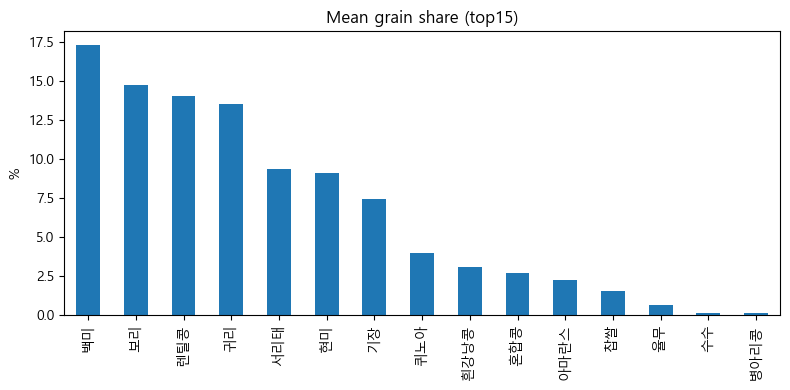

In [24]:
import pandas as pd, json, ast, numpy as np, matplotlib.pyplot as plt

df = pd.read_csv("results_no_avoid.csv")

def parse_json(s):
    if pd.isna(s): return {}
    try: return json.loads(s)
    except: 
        try: return ast.literal_eval(s)
        except: return {}

mix_dicts   = df["추천 믹스"].map(parse_json)   # {곡물: 비율%}
score_dicts = df["점수"].map(parse_json)       # {항목: 점수} 또는 total 포함

mix_df = pd.DataFrame(list(mix_dicts)).fillna(0.0)
mix_df.columns = [str(c) for c in mix_df.columns]

# Top-1 곡물 / 평균 비율
df["TOP1"] = mix_df.idxmax(axis=1)
mean_share = mix_df.mean().sort_values(ascending=False)

# 총점(키가 'total'이면 그 값, 아니면 합계)
def total_score(d):
    if isinstance(d, dict) and "total" in d: 
        return d["total"]
    return float(np.sum(list(d.values()))) if isinstance(d, dict) else np.nan
df["TOTAL_SCORE"] = score_dicts.map(total_score)



# 2) 평균 곡물 비율 상위 15
plt.figure(figsize=(8,4))
mean_share.head(15).plot(kind="bar")
plt.title("Mean grain share (top15)"); plt.ylabel("%"); plt.tight_layout(); plt.show()



### b. 질문·보기별 곡물 통계 (표)
질문–보기 조합별 곡물 출현 횟수와 평균 배합 비율을 정리한 표입니다.  
결과는 `grain_stats_by_question_option.xlsx`에 시트별로 저장됩니다.


In [13]:
# === 설정 ===
CSV_PATH = "results_no_avoid_k5.csv"
OUT_XLSX = "grain_stats_by_question_option.xlsx"
PRESENCE_THRESHOLD = 0.0

import pandas as pd, numpy as np, json, ast, re

def parse_json(s):
    if pd.isna(s): return {}
    try: return json.loads(s)
    except:
        try: return ast.literal_eval(s)
        except: return {}

# 데이터 로드
df = pd.read_csv(CSV_PATH)
mix_dicts = df["추천 믹스"].map(parse_json)
mix_df = pd.DataFrame(list(mix_dicts)).fillna(0.0)
mix_df.columns = [str(c) for c in mix_df.columns]

if "곡물 수" in df.columns:
    keep = df["곡물 수"] == 5
    df = df.loc[keep].reset_index(drop=True)
    mix_df = mix_df.loc[keep].reset_index(drop=True)

RESERVED = {"추천 믹스","점수","실행시각","TOTAL_SCORE","TOP1","_MIX_DICT"}
question_cols = [c for c in df.columns if c not in RESERVED and not c.startswith("Unnamed")]
question_cols = [c for c in question_cols if df[c].nunique(dropna=False) > 1]
print("질문 컬럼:", question_cols)

def grain_stats_by_questions(df_meta, mix_tbl, question_cols, presence_threshold=0.0):
    out = []
    for q in question_cols:
        vals = df_meta[q].fillna("None")
        for opt, idx in vals.groupby(vals).groups.items():
            sub = mix_tbl.loc[idx]
            pres = sub.gt(presence_threshold)
            cnt = pres.sum()

            mean_pres = pd.Series(0.0, index=sub.columns)
            nz = cnt[cnt > 0].index
            if len(nz) > 0:
                mean_pres.loc[nz] = (sub[nz].where(pres[nz]).sum() / cnt[nz])

            mean_all = sub.mean()
            tmp = pd.DataFrame({
                "question": q,
                "option": opt,
                "grain": sub.columns,
                "count": cnt.values,
                "mean_share_present": mean_pres.values,
                "mean_overall": mean_all.values
            })
            out.append(tmp)
    stats = pd.concat(out, ignore_index=True)
    stats["mean_share_present"] = stats["mean_share_present"].round(2)
    stats["mean_overall"]      = stats["mean_overall"].round(2)
    stats = stats.sort_values(["question","option","count","mean_share_present"],
                              ascending=[True, True, False, False], ignore_index=True)
    return stats

stats_all = grain_stats_by_questions(df, mix_df, question_cols, PRESENCE_THRESHOLD)

# -------- 시트명 정규화(+중복 방지) --------
INVALID = r'[:\\/?*\[\]]'  # 엑셀 금지 문자
def sanitize_sheet_name(name: str) -> str:
    s = re.sub(INVALID, "-", str(name))
    s = s.strip()
    return s[:31] if len(s) > 31 else s

def save_stats_per_question(stats_df: pd.DataFrame, out_xlsx: str):
    # openpyxl 우선, 없으면 xlsxwriter, 둘 다 없으면 안내
    engine = None
    try:
        import openpyxl  # noqa
        engine = "openpyxl"
    except ModuleNotFoundError:
        try:
            import xlsxwriter  # noqa
            engine = "xlsxwriter"
        except ModuleNotFoundError:
            raise ModuleNotFoundError(
                "엑셀 저장 엔진이 없습니다. 아래 중 하나를 설치하세요:\n"
                "%pip install openpyxl  또는  %pip install XlsxWriter"
            )

    used = set()
    def unique_sheet_name(base: str) -> str:
        name = sanitize_sheet_name(base)
        if name not in used:
            used.add(name); return name
        i = 2
        while True:
            cand = sanitize_sheet_name(f"{name[:28]}_{i}")  # 31자 제한
            if cand not in used:
                used.add(cand); return cand
            i += 1

    with pd.ExcelWriter(out_xlsx, engine=engine) as writer:
        for q in question_cols:
            sub = stats_df[stats_df["question"] == q]
            sheet = unique_sheet_name(q)
            sub.to_excel(writer, index=False, sheet_name=sheet)
    print("저장 완료 →", out_xlsx, f"(engine={engine})")

save_stats_per_question(stats_all, OUT_XLSX)

# 원하면 CSV 단일 파일도 함께 저장:
# stats_all.to_csv("grain_stats_by_question_option.csv", index=False, encoding="utf-8-sig")


질문 컬럼: ['취식 목적', '현재 건강 이슈', '나이', '성별', '선호식감/맛', '섭취 빈도', '알레르겐 회피(글루텐)']
저장 완료 → grain_stats_by_question_option.xlsx (engine=openpyxl)


### c. 질문별 보기별 곡물 시각화

아래 그래프들은 각 질문–보기 조합에서 곡물 출현 횟수와 평균 배합 비율을 보여줍니다.


In [14]:
# ===== 0) 한글 폰트 설정 (1회) =====
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

CANDIDATES = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
available = {f.name for f in font_manager.fontManager.ttflist}
for f in CANDIDATES:
    if f in available:
        rcParams["font.family"] = f
        break
rcParams["axes.unicode_minus"] = False

# ===== 1) 유틸 =====
import os, re
import pandas as pd

def sanitize(s: str) -> str:
    s = re.sub(r'[\\/:*?"<>|]+', "_", str(s))
    return re.sub(r"\s+", "_", s).strip("_")

def topn_for_option(stats_df: pd.DataFrame, question: str, option: str, metric: str, topn: int = 15):
    """
    metric: 'count' 또는 'mean_share_present'
    반환: 해당 (질문, 보기)에서 metric 기준 상위 topn의 (grain, value) 표
    정렬 규칙:
      - count 그래프: count desc, tie-breaker mean_share_present desc
      - mean_share 그래프: mean_share_present desc, tie-breaker count desc
    """
    sub = stats_df[(stats_df["question"] == question) & (stats_df["option"] == option)].copy()

    if metric == "count":
        sub = sub.sort_values(["count", "mean_share_present"], ascending=[False, False]).head(topn)
        x = sub["count"]; title_suffix = "출현 횟수(건)"
    elif metric == "mean_share_present":
        sub = sub[sub["count"] > 0]  # 등장 안 한 곡물 제외
        sub = sub.sort_values(["mean_share_present", "count"], ascending=[False, False]).head(topn)
        x = sub["mean_share_present"]; title_suffix = "등장 시 평균 배합비(%)"
    else:
        raise ValueError("metric must be 'count' or 'mean_share_present'")

    y = sub["grain"]
    return y, x, title_suffix

def plot_option_bar(stats_df: pd.DataFrame, question: str, option: str,
                    metric: str = "count", topn: int = 15,
                    save_dir: str | None = None, show: bool = True):
    """
    (질문, 보기) 단위로 수평 막대 그래프 1개 생성
    metric='count' 또는 'mean_share_present'
    """
    y, x, title_suffix = topn_for_option(stats_df, question, option, metric, topn)

    plt.figure(figsize=(9, 5))
    bars = plt.barh(y, x)           
    plt.gca().invert_yaxis()        # 상위가 위로 오도록
    plt.title(f"[{question}] {option} - {title_suffix}")
    plt.xlabel("건수" if metric == "count" else "%")
    
    # ===== 막대 끝 수치 표시 =====
    for bar, val in zip(bars, x):
        plt.text(bar.get_width() + (max(x) * 0.01),   # x 위치 (막대 끝 + 약간 오른쪽)
                 bar.get_y() + bar.get_height()/2,   # y 위치 (막대 중앙)
                 f"{val:.0f}" if metric=="count" else f"{val:.1f}%", 
                 va="center", ha="left", fontsize=9)

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fname = f"{sanitize(question)}__{sanitize(option)}__{metric}.png"
        out = os.path.join(save_dir, fname)
        plt.savefig(out, dpi=150)
    if show:
        plt.show()
    else:
        plt.close()


def plot_all_options_for_question(stats_df: pd.DataFrame, question: str,
                                  topn: int = 15, save_dir: str | None = "figs",
                                  show: bool = False, do_count: bool = True, do_mean: bool = True):
    """
    특정 질문의 모든 보기(option)에 대해:
      - 출현 횟수(count) 그래프
      - 등장 시 평균 배합비(mean_share_present) 그래프
    를 각각 개별 플롯으로 생성/저장
    """
    options = stats_df.loc[stats_df["question"] == question, "option"].dropna().unique().tolist()
    for opt in options:
        if do_count:
            plot_option_bar(stats_df, question, opt, metric="count", topn=topn, save_dir=save_dir, show=show)
        if do_mean:
            plot_option_bar(stats_df, question, opt, metric="mean_share_present", topn=topn, save_dir=save_dir, show=show)

# ===== 2) 사용 예시 =====
# (1) 질문 목록 확인
questions = stats_all["question"].unique().tolist()
print("질문 목록:", questions)

# (2) 특정 질문 하나만 먼저 생성/저장
# 예: "취식 목적"의 모든 보기별로 Count/Mean 그래프 생성 → ./figs 폴더에 PNG 저장
#plot_all_options_for_question(stats_all, question="취식 목적", topn=15, save_dir="figs", show=False)

# (3) 전 질문 일괄 저장(생성 그래프가 많아질 수 있음)
for q in questions:
    plot_all_options_for_question(stats_all, question=q, topn=15, save_dir="figs", show=False)


질문 목록: ['나이', '선호식감/맛', '섭취 빈도', '성별', '알레르겐 회피(글루텐)', '취식 목적', '현재 건강 이슈']


## 파일 교체 가이드
- **설문 문항 추가/수정**: `config/survey_schema.json`에 섹션 정의 추가 → 드롭다운/선택지/기본값 지정
- **섹션 가중치 변경**: `config/section_weights.csv` 수정 → 합계는 코드에서 자동 정규화
- **영양성분표 교체**: 
  - `config/survey_to_nutrients.csv`: *섹션, 보기, (1/2/3)랭크 → 영양* 행 추가/수정
  - `config/nutrient_to_grains.csv`: *영양 → (1/2/3)랭크 잡곡* 행 추가/수정
- **기타 규칙(캡/최소치/알레르겐/베이스 등)**: `config/rule_weights.json` 편집
